<a href="https://colab.research.google.com/github/riya-chougule/Image_segmentation_for_self_driving_cars_using_deep_learning_techniques/blob/main/prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
import PIL
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path_data = Path('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg')
path_lbl = path_data/'labels'
path_img = path_data/'images'

In [4]:
print (path_data)
print (path_lbl)
print (path_img)

/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg
/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/labels
/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images


In [5]:
fnames = get_image_files(path_img/'train', recurse = True)
fnames[:3]

[PosixPath('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/train/9ce73308-16f9a217.jpg'),
 PosixPath('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/train/96bbfee1-9cf45d08.jpg'),
 PosixPath('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/train/a12d8ff4-c8c0b1fc.jpg')]

In [6]:
lbl_names = get_image_files(path_lbl, recurse = True)
lbl_names[:3]

[PosixPath('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/labels/train/c31aa396-beb4f81b_train_id.png'),
 PosixPath('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/labels/train/7c302d09-d4da21c8_train_id.png'),
 PosixPath('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/labels/train/c2509294-f6bd70dc_train_id.png')]

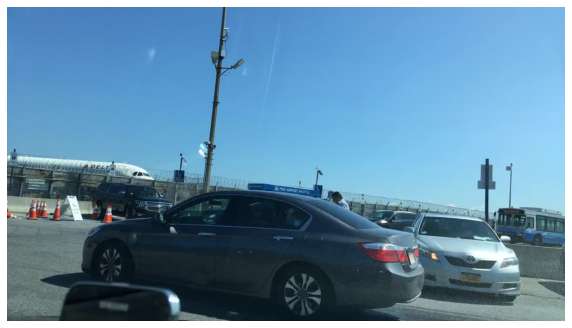

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(10,10))

In [8]:
get_y_fn = lambda x: path_lbl/x.parts[-2]/f'{x.stem}_train_id.png'
img_f, get_y_fn(img_f)

(PosixPath('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/train/9ce73308-16f9a217.jpg'),
 PosixPath('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/labels/train/9ce73308-16f9a217_train_id.png'))

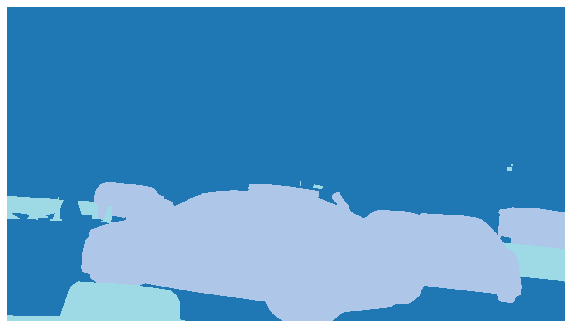

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(10,10), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([ 720, 1280]), tensor([[[ 10,  10,  10,  ...,   0,   0,   0],
          [ 10,  10,  10,  ...,  10,  10,  10],
          [ 10,  10,  10,  ...,  10,  10,  10],
          ...,
          [255, 255, 255,  ...,   0,   0,   0],
          [255, 255, 255,  ...,   0,   0,   0],
          [255, 255, 255,  ...,   0,   0,   0]]]))

In [11]:
size = (180, 320)
bs = 16

In [25]:
segmentation_classes = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car',
    'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'void'
]
void_code = 20

In [26]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_folder(train='train', valid='val')
       .label_from_func(get_y_fn, classes = segmentation_classes))

In [27]:
src.train.y.loss_func

FlattenedLoss of CrossEntropyLoss()

In [28]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [29]:
data

ImageDataBunch;

Train: LabelList (7000 items)
x: SegmentationItemList
Image (3, 180, 320),Image (3, 180, 320),Image (3, 180, 320),Image (3, 180, 320),Image (3, 180, 320)
y: SegmentationLabelList
ImageSegment (1, 180, 320),ImageSegment (1, 180, 320),ImageSegment (1, 180, 320),ImageSegment (1, 180, 320),ImageSegment (1, 180, 320)
Path: /content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images;

Valid: LabelList (1000 items)
x: SegmentationItemList
Image (3, 180, 320),Image (3, 180, 320),Image (3, 180, 320),Image (3, 180, 320),Image (3, 180, 320)
y: SegmentationLabelList
ImageSegment (1, 180, 320),ImageSegment (1, 180, 320),ImageSegment (1, 180, 320),ImageSegment (1, 180, 320),ImageSegment (1, 180, 320)
Path: /content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images;

Test: None

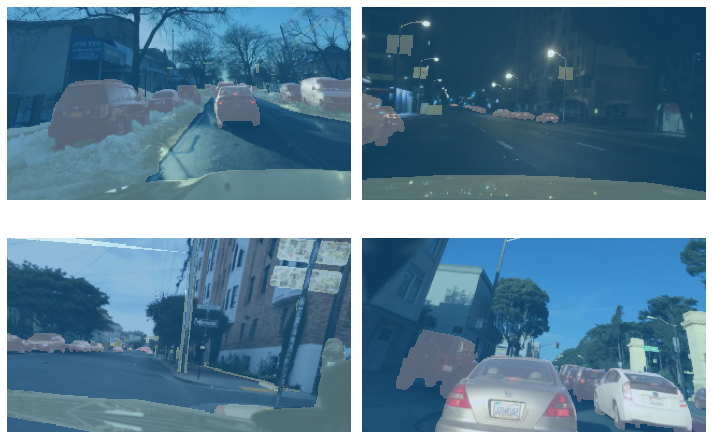

In [31]:
data.show_batch(2, figsize=(10,7))

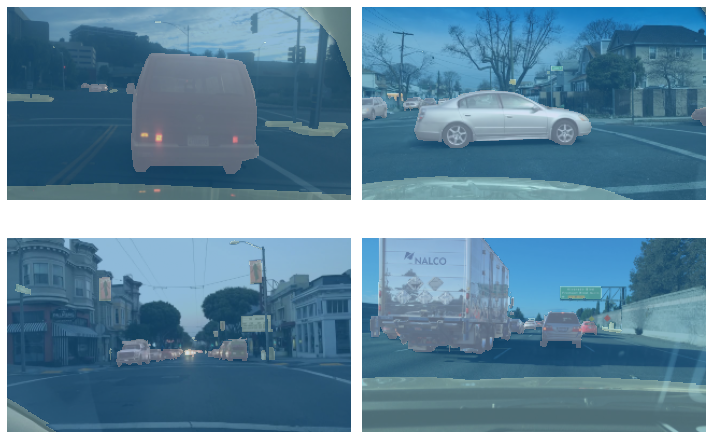

In [32]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [33]:
def acc(input, target):
    target = target.squeeze(1)
    mask = target != 20
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [34]:
metrics=acc
wd=1e-5

In [35]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [36]:
learn.model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [37]:
lr_find(learn)

epoch,train_loss,valid_loss,acc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


IndexError: ignored